In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import base
from IPython.display import display, HTML
import math
import time
import utm
from datetime import datetime, timedelta
import matplotlib.animation as animation

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor


## Map utils

In [4]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 


global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111



## Entreno el modelo que vamos a usar para predecir

In [5]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [6]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [7]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

## Levanto datos de validacion

In [8]:
validation_track = sc.read.csv('datos/validation_birds_tracks.csv', header=True)

In [9]:
def add_utm_coordinates(row):
    row_dict = row.asDict()
    x, y,_,_ = utm.from_latlon(float(row['Latitud']), float(row['Longitud']))
    row_dict['x'] = x
    row_dict['y'] = y
    return row_dict

def add_timestamp(row):
    row['timestamp'] = '{} {}'.format(
        datetime.strptime(row['Fecha'], '%m/%d/%Y').strftime('%Y-%m-%d'),
        row['Hora']
    )
    return row

In [10]:
validation_track = validation_track.rdd.map(add_utm_coordinates).map(add_timestamp)

In [11]:
validations_list = validation_track.collect()

In [12]:
validation_days = set([e['timestamp'].split()[0] for e in validations_list])
validation_birds = set([int(e['ID']) for e in validations_list])

## Levanto el archivo con las emisiones de los pajaros

In [13]:
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
birds_recep = birds_recep.filter(lambda x: x['timestamp'].split()[0] in validation_days and x['tag_id'] in validation_birds)
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

### Mapa con el movimiento predicho para un pajaro cerca del momento de validacion

In [161]:
validation_point = validation_track.take(48)[47]
validation_point = normalizer._normalize_positions(validation_point)

In [162]:
def update_animation(data, p):
    x = data[0]
    y = data[1]
    p.set_data(x, y)
    plt.title(data[7])
    return p
 

def show_birds_movement(predictions, delay=200):
    fig, ax = plt.subplots()
    point, = ax.plot([0], [0], 'go', color='red')
    point.set_data(0, 0)
    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
    plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
    for antenna in range(4):
            pos_antena = posicion_antenas[antenna]
            plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
    ani = animation.FuncAnimation(fig, update_animation, predictions, interval=delay, fargs=(point,))


In [163]:
BIRD_TAG_ID = int(validation_point['ID'])
START_TIME = (
    (datetime.strptime(validation_point['timestamp'], '%Y-%m-%d %H:%M:%S')-timedelta(seconds=60*2))
    .strftime('%Y-%m-%d %H:%M:%S')
)
END_TIME = (
    (datetime.strptime(validation_point['timestamp'], '%Y-%m-%d %H:%M:%S')+timedelta(seconds=60*2))
    .strftime('%Y-%m-%d %H:%M:%S')
)

single_bird = (
    birds_recep
    .filter(lambda x: x['tag_id'] == BIRD_TAG_ID)
    .filter(lambda x: x['timestamp'] >= START_TIME)
    .filter(lambda x: x['timestamp'] < END_TIME)
)

birds_data = pd.DataFrame(single_bird.collect()).drop(columns=[4,5])

In [164]:
predictions = predictor.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), pd.DataFrame(single_bird.collect())], axis=1).values

In [165]:
from utils.smoother import Smoother

smoother = Smoother(window_threshold=300)
#smooth_predictions_np = smoother.smooth_predictions(predictions)
smooth_predictions_np = predictions
#smooth_predictions_np = smoother.filter_predictions(predictions)

In [166]:
len(smooth_predictions_np)

16

<IPython.core.display.Javascript object>


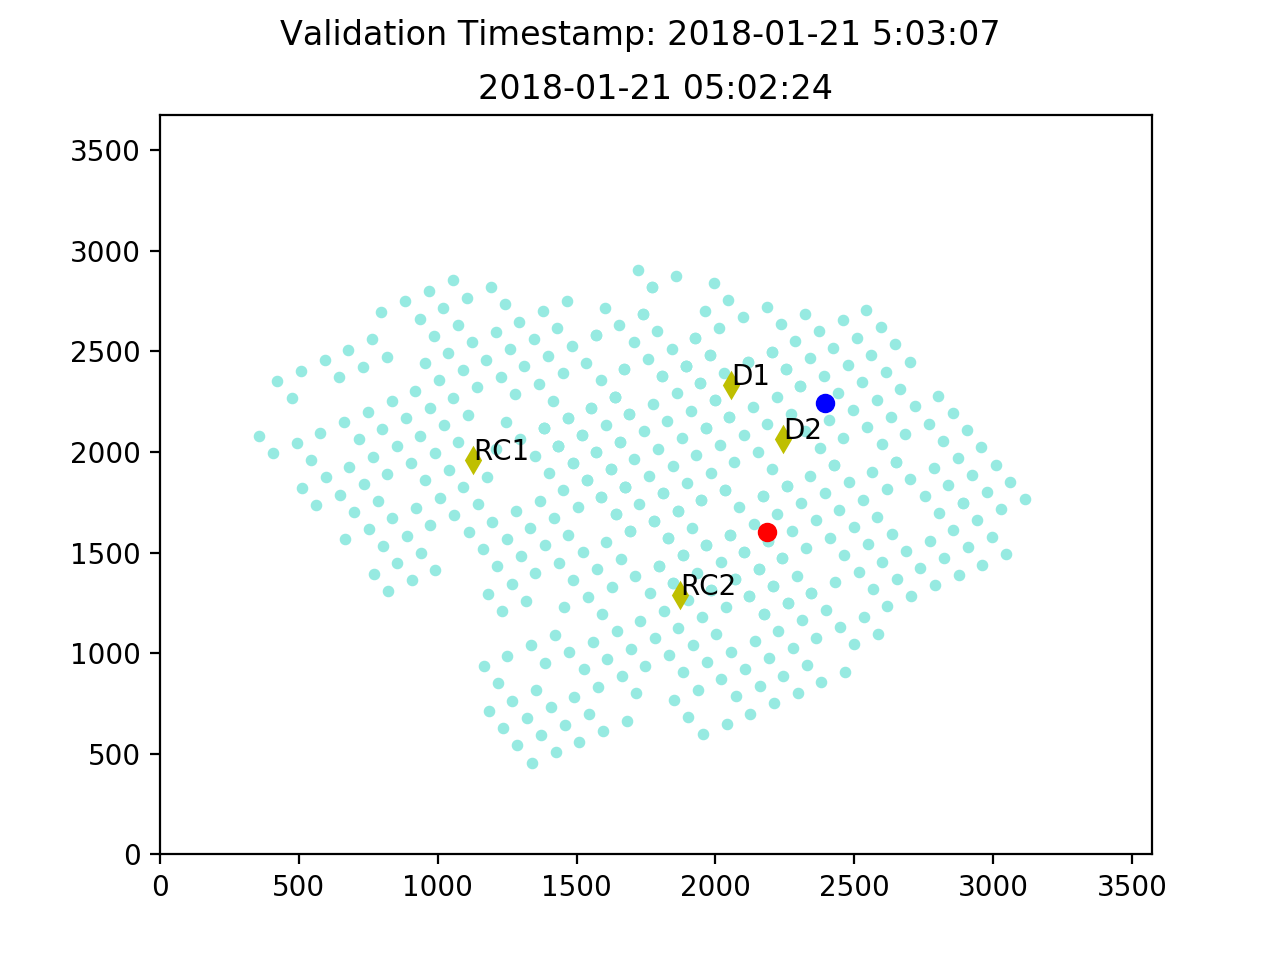

In [167]:
DELAY = 300

fig, ax = plt.subplots()
point, = ax.plot([0], [0], 'go', color='red')
fig.suptitle('Validation Timestamp: {}'.format(validation_point['timestamp']))
ax.plot([validation_point['x']], [validation_point['y']], 'go', color='blue') # plot real position
point.set_data(0, 0)
plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalizer._normalize_positions).collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        name = nombre_antenas[antenna]
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 
        
ani = animation.FuncAnimation(fig, update_animation, smooth_predictions_np, interval=DELAY, fargs=(point,), repeat=False)



<IPython.core.display.Javascript object>


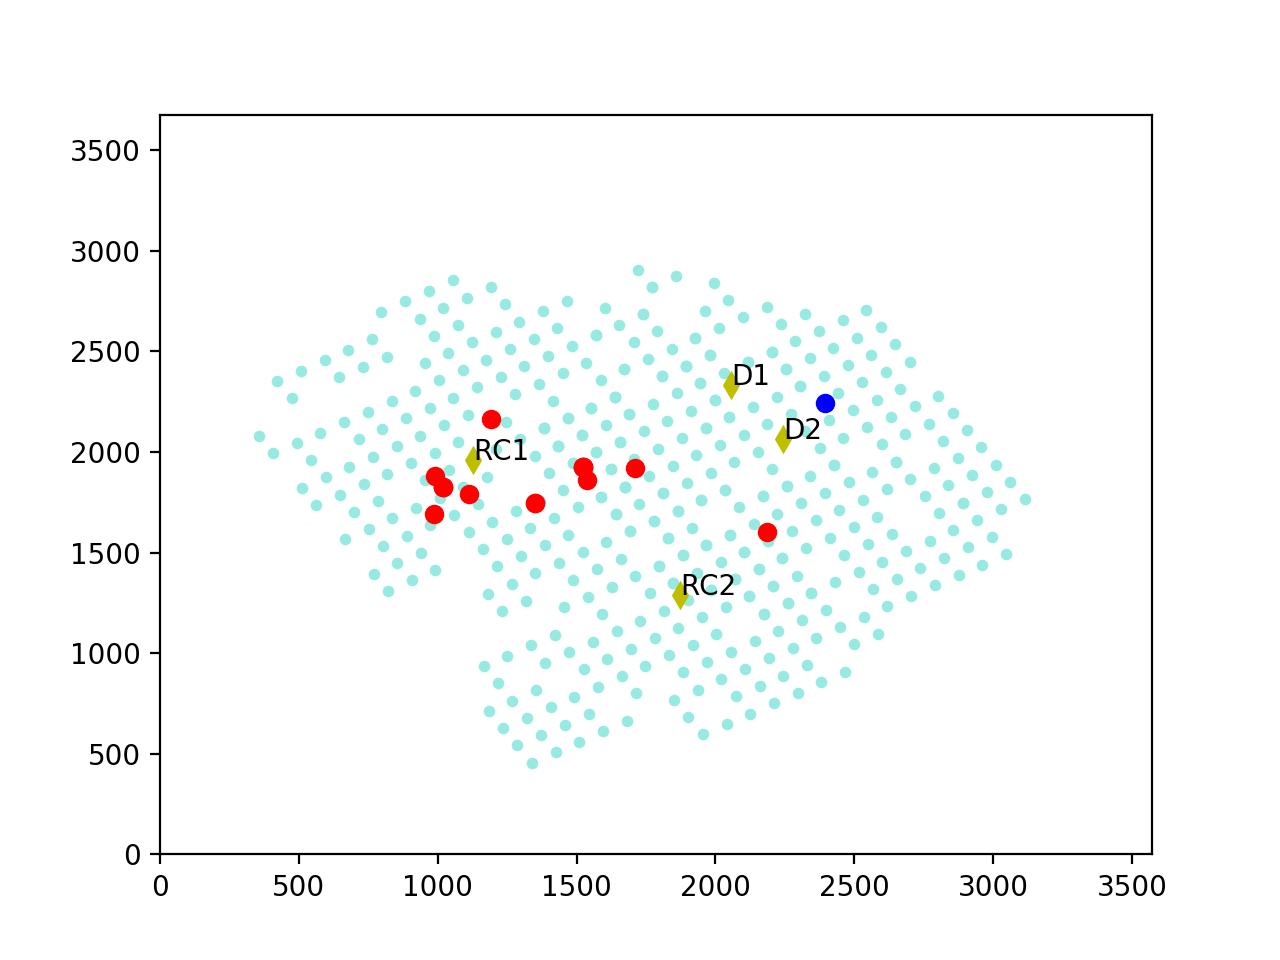

In [168]:
DELAY = 300

fig, ax = plt.subplots()
#fig.suptitle('Validation Timestamp: {}'.format(validation_point['timestamp']))

plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalizer._normalize_positions).collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        name = nombre_antenas[antenna]
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 
        
for point in smooth_predictions_np:
    ax.plot(point[0], point[1], 'go', color='red')

ax.plot([validation_point['x']], [validation_point['y']], 'go', color='blue') # plot real position


